In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats

## Загрузка и неформальная проверка данных

In [2]:
# создаем подключение, проверяем, что связь есть, смотрим, что данные возвращаются адекватные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'####'
            }

query = '''
        select post_id, 
               countIf(action = 'view') as views, 
               countIf(action = 'like') as likes, 
               uniq(user_id) as uniq_users 
        from {db}.feed_actions 
        where toDate(time) = yesterday() 
        group by post_id 
        order by views desc 
        limit 10
        '''

df_0 = ph.read_clickhouse(query, connection=connection)

In [3]:
df_0.describe()

,post_id,views,likes,uniq_users
count,10.00000,10.000000,10.000000,10.000000
mean,6187.90000,15522.800000,4301.700000,11120.200000
std,34.95219,1697.394657,714.739743,814.269516
min,6103.00000,13644.000000,3453.000000,10195.000000
25%,6173.50000,14443.000000,3858.500000,10575.250000
50%,6200.00000,14910.000000,4095.500000,10837.500000
75%,6208.75000,16156.500000,4586.250000,11424.750000
max,6220.00000,19051.000000,5816.000000,12780.000000


## Извлечение нужных групп, их предварительный анализ

In [4]:
# подключились к БД и выполнили запрос по извлечению всех пользователей в группе 2 и 3 в нужном временном интервале и информации по ним (ctr на каждого userа)
q1 = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-08-27' and '2022-09-02'
        and exp_group in (2,3)
    GROUP BY exp_group, user_id
    """
df = ph.read_clickhouse(q1, connection=connection)

In [5]:
# вывели число пользователей в получившихся группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


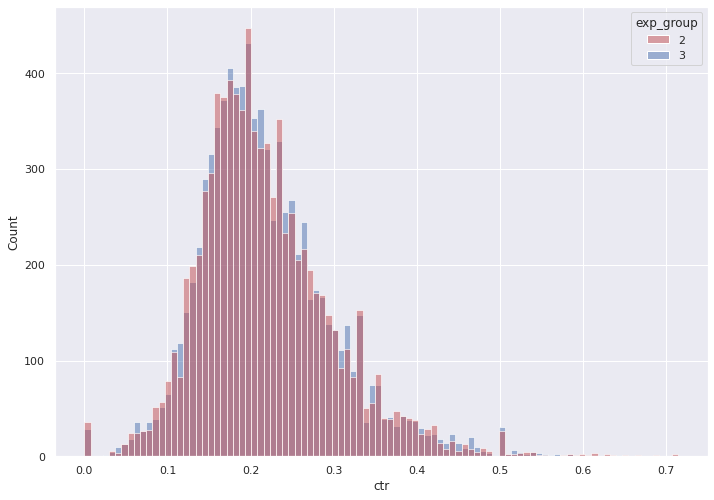

In [6]:
# сделали графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})
# гистограммы по обоим группам вместе (на одном рисунке)
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [7]:
# получение результатов t-test по группам 2 и 3 (целым) по показателю ctr
t_res = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
t_res.pvalue

0.45969873156476293

In [8]:
# получение результатов Манна-Уитни по группам 2 и 3 (целым) по показателю ctr
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 3].ctr,
                   alternative = 'two-sided')


MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

Выводы: по обоим критериям pvalue > 0.05, различий между группами 2 и 3 (по всем значениям одновременно в каждой из них), нет.

## Собственно решение задачи 1 
(проверяем корректность системы сплитования, используя бутстреп)

In [9]:
# формируем выборку значений pvalue в виде списка p_list
sample_length = 500
number_of_samples = 10000
p_list = []
for _ in range(number_of_samples):
    a_i = df[df.exp_group == 2].ctr.sample(sample_length, replace = False).tolist()
    b_i = df[df.exp_group == 3].ctr.sample(sample_length, replace = False).tolist()
    t_res = stats.ttest_ind(a_i, b_i, equal_var=False)
    p_list.append(t_res.pvalue)
#p_list

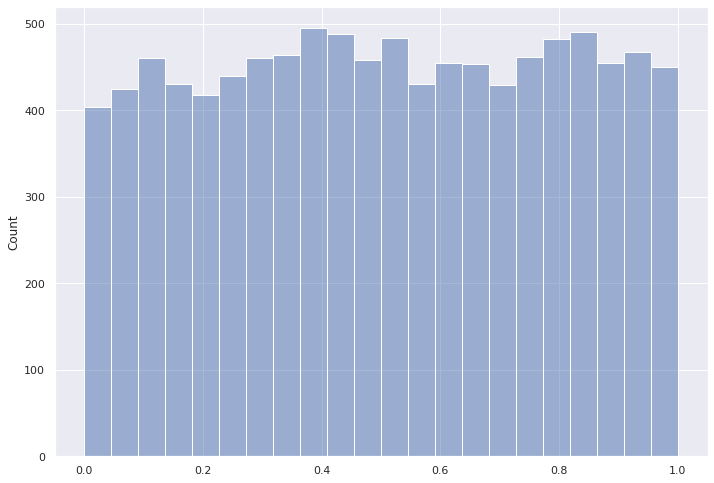

In [10]:
# строим гистограмму полученных значений pvalue
groups = sns.histplot(data = p_list, alpha=0.5, kde=False)

In [11]:
# теперь рассчитываем процент тех значений,которые меньше 0.05
pvl = pd.DataFrame(p_list)
p_0_05_perc = 100*(pvl[pvl <= 0.05].count()/number_of_samples)
p_0_05_perc

0    4.47
dtype: float64

Полученное значение в 4.47% (при том запуске, в котором сохранен ноутбук!) довольно близко к требуемым 5%. И требование о том, чтобы ошибка 1 рода не превышала 5% (при справедливости предположения о равенстве средних в выборках А (группа 2) и В (группа 3)) выполняется. Значит, нет оснований считать, что рассматриваемые выборки различаются в средних значениях. Поскольку это и необходимо на этапе запуска АА-теста, можно считать, что система сплитования  показала себя хорошо (а данные достаточно хорошо представляют генеральную совокупность), и ее можно запускать для проверки АВ-теста.     

In [13]:
# альтернативный способ - найти выборочный квантиль на уровне 0,05, и определить, насколько он оказался близок к требуемому значению 0.05 
pvl.quantile(q=0.05) 

0    0.055021
Name: 0.05, dtype: float64

Выводы, как это и было ожидаемо, в целом такие же, как и по предыдущему способу - система сплитования работает хорошо, поскольку значение 0.055021 близко к значению 0.05.